# Dog Breed Classification

## Introduction

[ImageNet](https://www.image-net.org/) is one of the most popular datasets in computer vision, used mainly for image classification and localisation. Due to its vast size, subsets of this dataset can also be constructed to focus on specific problems. One such dataset is the [Stanford Dogs Dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset/data), containing images of several breeds of dogs, designed for fine-grained image categorisation.

In this assignment, you will be constructing and training neural network-based models to identify the breed of the dog shown in an image. Therefore, the models that will be considered fall under the category of object recognition. Hence, many concepts in related fields (e.g. face recognition) are also applicable here.

**Acknowledgements**

The original data source can be found at http://vision.stanford.edu/aditya86/ImageNetDogs/.

*⚠️ NOTE: The link does not use https to establish a secure connection and thus you may get a security warning if you attempt to access it. Instructions on how to use the dataset will be given below.*

**Reference:**

  Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao and Li Fei-Fei. Novel dataset for Fine-Grained Image Categorization. First Workshop on Fine-Grained Visual Categorization (FGVC), IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2011.

**ImageNet Reference:**

  J. Deng, W. Dong, R. Socher, L.-J. Li, K. Li and L. Fei-Fei, ImageNet: A Large-Scale Hierarchical Image Database. IEEE Computer Vision and Pattern Recognition (CVPR), 2009.

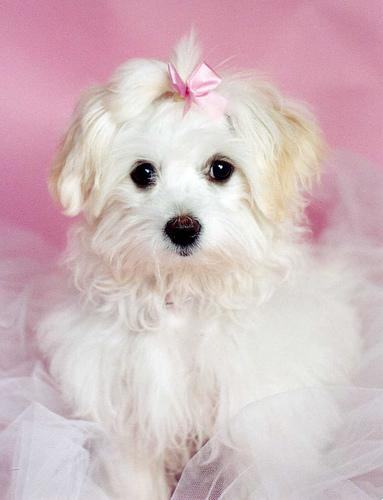

## Instructions
- The dataset is available by accessing the MECC storage (via Networks labs PCs), at `/opt/nfs/shared/images/ImageNetDogs`. The files and folders of interest are as follows:
 - **Images**: Image files
 - **Annotation**: Annotation files, containing metadata such as bounding boxes around the dog in the image
 - **README.txt**: Some information on the dataset

 *⚠️ NOTE: For this assignment, you DO NOT need to use any other files, such as file_list.mat, test_data.mat, etc.*

- This assignment is to be attempted individually.

- All code needs to be developed in Python 3. This Jupyter notebook should be used, and uploaded to the VLE once complete.

- Computers in the Networks lab can be used to train the models required to complete this assignment. It is HIGHLY recommended to use the GPUs.

- Any textual or visual information and equations that might need to be conveyed is expected to be written using the Markdown language.

- The Jupyter notebook to be submitted should be named as follows:

  `name-surname-idnumber.ipynb`

- The list of packages that are allowed for this assignment are as follows: `matplotlib`, `os`, `numpy`, `torch`, `open-cv`, `xml`, `PIL`, `torchvision` and any other packages agreed with the lecturer.

- If you use any information or material from books, papers, websites, etc., please ensure that the appropriate citations are included.

- The deadline for this assignment is **Friday, 17th January 2025 at 15:00**.

## Package Imports

Import all of the packages required in the notebook

In [8]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import os
import shutil
import numpy as np
import random


## The Data

### **Q1: Dataset Exploration** ###

Explore the dataset, to determine the characteristics of the data that you're using. Write down any observations.

*ℹ️ NOTE: Feel free to display a few examples, to get an idea of the image characteristics. Observing and understanding the characteristics of a dataset should help you design an effective way to split your data and any precautions or considerations requred when constructing your models (e.g. identifying any issues that may arise, allowing you to take preventative action). Things you could check out include the image quality, resolution, total number of images, number of classes, distribution of the number of images per class, etc.*

**(5 marks)**

Directory structure:
Annotation
file_list.mat
Images
README.txt
test_data.mat
test_list.mat
train_data.mat
train_list.mat

Images folder structure:
/opt/nfs/shared/images/ImageNetDogs/Images/n02085620-Chihuahua:                      directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02085782-Japanese_spaniel:               directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02085936-Maltese_dog:                    directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02086079-Pekinese:                       directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02086240-Shih-Tzu:                       directory

Image formats:
/opt/nfs/shared/images/ImageNetDogs/Images/n02085620-Chihuahua/n02085620_10074.jpg: JPEG image data, JFIF standard 1.01, aspect ratio, density 1x1, segment length 16, baseline, precision 8, 333x500, components 3

Total number of images:
20580

Number of Categories:
120

Random images:


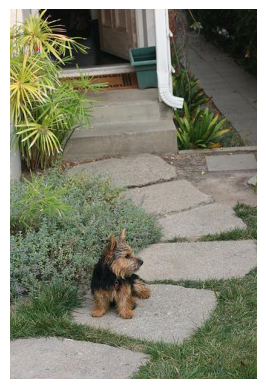


Image resolution:
  Geometry: 333x500+0+0
  Page geometry: 333x500+0+0

Image format and quality:
  Format: JPEG (Joint Photographic Experts Group JFIF format)
  Quality: 75


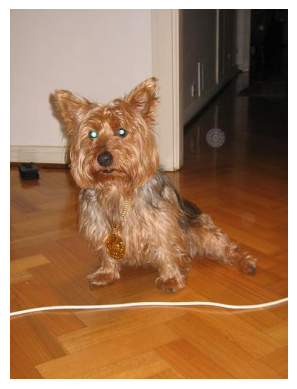


Image resolution:
  Geometry: 375x500+0+0
  Page geometry: 375x500+0+0

Image format and quality:
  Format: JPEG (Joint Photographic Experts Group JFIF format)
  Quality: 75


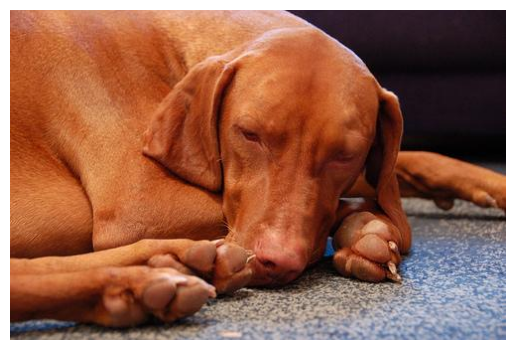


Image resolution:
  Geometry: 500x333+0+0
  Page geometry: 500x333+0+0

Image format and quality:
  Format: JPEG (Joint Photographic Experts Group JFIF format)
  Quality: 75


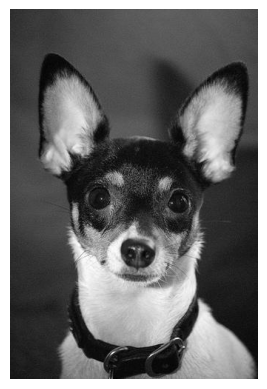


Image resolution:
  Geometry: 335x500+0+0
  Page geometry: 335x500+0+0

Image format and quality:
  Format: JPEG (Joint Photographic Experts Group JFIF format)
  Quality: 75

Corrupted images:


In [9]:
# Define dataset directory
directory = '/opt/nfs/shared/images/ImageNetDogs'

# List dataset contents
print("Directory structure:")
os.system(f'ls {directory}')

# Check the structure of the Images Folder
print("\nImages folder structure:")
os.system(f'file {directory}/Images/* | head -n 5')

# Check the format of the images in the dataset
print("\nImage formats:")
os.system(f'file {directory}/Images/n02085620-Chihuahua/* | head -n 1')

# Number of total images in Images folder
print("\nTotal number of images:")
os.system(f'find {directory}/Images -type f | wc -l')

# Number of Categories
print("\nNumber of Categories:")
os.system(f'ls {directory}/Images | wc -l')

# Load. display and analyze 4 random images
print("\nRandom images:")
for i in range(4):
    img_path = os.popen(f'find {directory}/Images -type f | shuf -n 1').read().strip()
    img = Image.open(img_path)
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Check the resolution of the image
    print("\nImage resolution:")
    os.system(f'identify -verbose {img_path} | grep -i geometry')

    # Check the format and quality of the image
    print("\nImage format and quality:")
    os.system(f'identify -verbose {img_path} | grep -i "format\|quality"')

# Check for any corrupted images
print("\nCorrupted images:")
os.system(f'find {directory}/Images -type f -exec identify -verbose {{}} \; | grep "Corrupt"')


# Check for duplicate images
print("\nDuplicate images:")
os.system(f'find {directory}/Images -type f -exec md5sum {{}} \; | sort | uniq -w 32 -dD')

**A1**:

***Directory Structure and README Analysis:***
- We first decided to check the directory structure to identify how the contents of the dataset are being stored.
- We then checked the README file to see if there was any additional information about the dataset.
- However, the README simply led us to the dataset link from Stanford.

***Dataset Overview:***
- In the Stanford link, we identified the number of categories (120 dog breeds), the average number of images per class (150), and the total number of images in the dataset (20,580).
- A quick scroll through the provided number of images per class showed that there were no outlier classes with significantly fewer images that would need to be addressed.
- These findings are confirmed in the code above.
- The Stanford link also gives a mean accuracy result based on the amount of training images per class.
- Naturally, the greater the amount of classes, the better the accuracy as it is able to distingues between more features, this at diminishing returns.
- However, this plot still has around 45 degree gradient on the higher end of images per class, suggesting the database size importance.


***Image Format and Quality Analysis:***
- We also analyzed the image format and quality of 4 random images from the dataset.
- It was noted that all images are in JPEG format and have varied resolutions, but the quality of the images is consistently 75.
- The quality index identifies the JPEG compression level, which ranges from 0 to 100, with 100 being the highest quality.

***Corrupt and Duplicate Images:***
- There are no corrupt images.
- There are duplicate images, either in the same class, which wouldn't have any impact on the model.
- There are also duplicate images across different classes, which could be due to crossbreeds.

### **Q2: Splitting the dataset** ###
Implement code to split the dataset in such a way as to enable training and testing of a machine learning model.

**(5 marks)**

In [ ]:
def split_dataset(data_dir, output_dir, train_ratio = 0.8, num_classes = None , seed = None , split_index = None):
    """
    Split the dataset into training and test sets

    Parameters:
    - data_dir: str, path to the dataset directory
    - output_dir: str, path to the output directory
    - train_ratio: float, ratio of the training set
    - num_classes: int, number of classes to consider
    - seed: int, seed for random number generator
    - split_index: int, index to split the dataset

    Returns:
    - None
    """

    # Set random seed for reproducibility if not None
    if seed is not None:
        random.seed(seed)

    # Get the list of breed classes (subdirectories)
    classes = sorted(os.listdir(data_dir))

    # Select a subset of classes if num_classes is not None
    if num_classes is not None:
        classes = classes[:num_classes]

    # Iterate over the classes and split the dataset
    for breed in classes:
        # Get the breed path
        breed_path = os.path.join(data_dir, breed)

        # Check if it is a valid directory
        if not os.path.isdir(breed_path):
            continue
            
        # Get the list of images
        images = os.listdir(breed_path)

        # If the split_index is not None, shuffle the images at specific seed
        if split_index is not None:
            random.seed(split_index)
        
        # Shuffle the images
        random.shuffle(images)

        # Determine the split point
        split_point = int(len(images) * train_ratio)
        train_images = images[:split_point]
        test_images = images[split_point:]
        print(f"Splitting {breed} into {len(train_images)} training and {len(test_images)} test images")

    print("Dataset split completed")

return None

### **Q3: Custom dataset in PyTorch** ###

A lot of effort in solving any machine learning and computer vision problem goes into preparing the data. PyTorch provides a simple mechanism to define a custom dataset using `torch.utils.data.Dataset`, which is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

- `__init__` so that it initialises the dataset
- `__len__` so that len(dataset) returns the size of the dataset.
- `__getitem__` to support the indexing such that `dataset[i]` can be used to get $i$-th sample.


Write a class `DataLoaderClassification` that can be used to
- Load the list of image filenames and the corresponding lables in two lists in `__init__`
- Load a batch of images and corresponding lables when one calls `__getitem__`
- Returns the length of the dataset using `__len__`

*ℹ️ NOTE: It is recommended to make use of the bounding boxes...*

**(5 marks)**

### **Q4: PyTorch dataloaders** ###

Write code that creates the PyTorch dataloaders to train and test the model.

**(5 marks)**

## Simple CNN

### **Q5: Define a simple CNN** ###

PyTorch provides the elegantly designed modules and classes, including `torch.nn`, to help you create and train neural networks. An `nn.Module` contains layers, and a method `forward(input)` that returns the output.

Write the `CNN` class to define a Convolutional Neural Network (CNN) where:
- The first convolutional layer (`conv1`) takes 3 input channels, outputs 16 output channels and has a kernel size of 5, a stride of 1, and padding of 2 pixels. The output of `conv1` is fed into a ReLU activation followed by a Max-pooling operator with a kernel size of 2.
- The second convolutional layer in this network (`conv2`) should have 32 filters with a kernel size of 5, a stride of 1, and padding of 2 pixels. This should be followed by a ReLU activation and a max-pooling operator with a kernel size of 2.
- The last layer is a fully-connected layer (`fc1`), which will finally output the dog breed that needs to be predicted.

In this code you should define the `__init__` and `forward` member functions.

Lastly, print the number of parameters in the model (using `torchsummary.summary`)

More information about `torch.nn` can be found [here](https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html).

**(10 marks)**

### **Q6: Train and evaluate the simple CNN** ###

1.   Write the code to train and evaluate the CNN specified in **Q5**. Use an Adam optimizer with the learning rate set to 0.001.
2.   Plot the accuracy against the number of epochs and write the highest accuracy achieved after 25 epochs.
3.   Save the best performing model in the folder `./Model/Simple-CNN/model.pth`.
4.   Write a function that takes as input (1) a model and (2) an image of a dog, and which outputs the dog's breed using the model.

*ℹ️ NOTE: Apart from the accuracy, feel free to check out any other metrics that may be of relevance. Apart from the overall performance, consider also checking out the performance across classes.*

*ℹ️ NOTE: The model should take less than 1 hour to train.*

**(15 marks)**

The best accuracy of the proposed network after 25 epochs is **?%**



Write a function that takes as input (1) a model and (2) an image of a dog, and which outputs the dog's breed using the model.

Try it out using an image in your testing set.

### **Q7: Improve the simple CNN's performance** ###

Provide an overview of the model's characteristics (e.g. hyperparameters) that can be modified to try and improve performance. Then, try to improve the performance, by varying some characteristics, and train *at least* 1 additional model.

Explain the reasoning behind the hyperparameters chosen for modification, and the reasoning behind the values that are set (e.g. if you reduce the learning rate, explain why you have done this).

Plot the accuracy against the number of epochs and write the highest accuracy achieved after 25 epochs. Show the results of any other metrics that are deemed relevant.

ℹ️ *NOTE: While it is not strictly necessary to improve performance (although desirable), it is important to discuss any increase or decrease in performance, across all evaluation metrics considered (i.e. discuss why did performance increase/decrease?)*

ℹ️ *NOTE: Do NOT change the number of epochs. Similar to the model in Q6, the models should take less than 1 hour each to train.**

**(10 marks)**

## Deep CNNs

### **Q8: Understanding deep CNN architectures proposed in literature** ###

There are several deep CNN methods that achieve very high classification rates. The following is a list of papers that you should check out:

1. Alexnet  [[1]](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
2. VGG model [[2]](https://www.robots.ox.ac.uk/~vgg/publications/2015/Simonyan15/simonyan15.pdf)
3. ResNet [[3]](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)

Discuss what innovations each network introduced, and what contributed to increased performance.

**(10 marks)**

**A8**: Write your answer here.


### **Q9: Define, train, and evaluate a deep CNN** ###

Based on your observations in **Q8**, write the class for a deep CNN model that aims to achieve a better performance than the simple CNN model above, explaining the reasoning behind the design of your model. The number of model parameters should be less than 75M.

Train the model, and plot the accuracy against the number of epochs and write the highest accuracy achieved after 50 epochs. Show the results of any other metrics that are deemed relevant, and discuss your observations.

*ℹ️ NOTE: The model should take less than 3 hours to train.*

**(10 marks)**

### **Q10: Perform Transfer Learning** ###

Use the [`vgg16_bn` *pre-trained* model](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16_bn.html#torchvision.models.vgg16_bn), using `weights='IMAGENET1K_V1'`, to perform transfer learning using the Stanford Dogs dataset.

Explain the modifications and implementations done to perform transfer learning, in the Markdown text cell below.

Based on your observations of the trained model's performance, try to improve the performance by training additional models (see the cell below for more details).

For each case:

* Plot the accuracy against the number of epochs and write the highest accuracy achieved after 50 epochs. Similar to previous questions, show the results of any other metrics that are deemed relevant.

* Discuss how you are performing the fine-tuning

* Discuss observations from model training and evaluation

*ℹ️ *NOTE: Feel free to use the function you created in Q6 to input an image and a model and output the breed of the dog depicted in the image as determined by the model.*

*ℹ️ NOTE: The model should take less than 2.5 hours to train.*

**(15 marks)**

**A10**: Write your answer here.

Try to improve the performance, by varying characteristics such as the model hyperparameters, and train *at least* 2 additional models.

For each model, explain the reasoning behind (1) the *characteristics* chosen for modification, and (2) the *values* that are set (e.g. if you reduce the learning rate, explain why you have done this).

*ℹ️ NOTE: As before, the models should take less than 2.5 hours each to train.*

## Conclusions & Future Work

### **Q11: Model Deployment** ###

Let's say that you are asked to deploy one of your models in practice. Which of the models that you have trained would you select, and why?

ℹ️ *NOTE: Compare your models, and discuss any advantages, limitations, and any future work that could be performed to make the chosen model more suitable for real-world deployment.*

**(10 marks)**

**A11**: Write your answer here.




**END OF ASSIGNMENT**

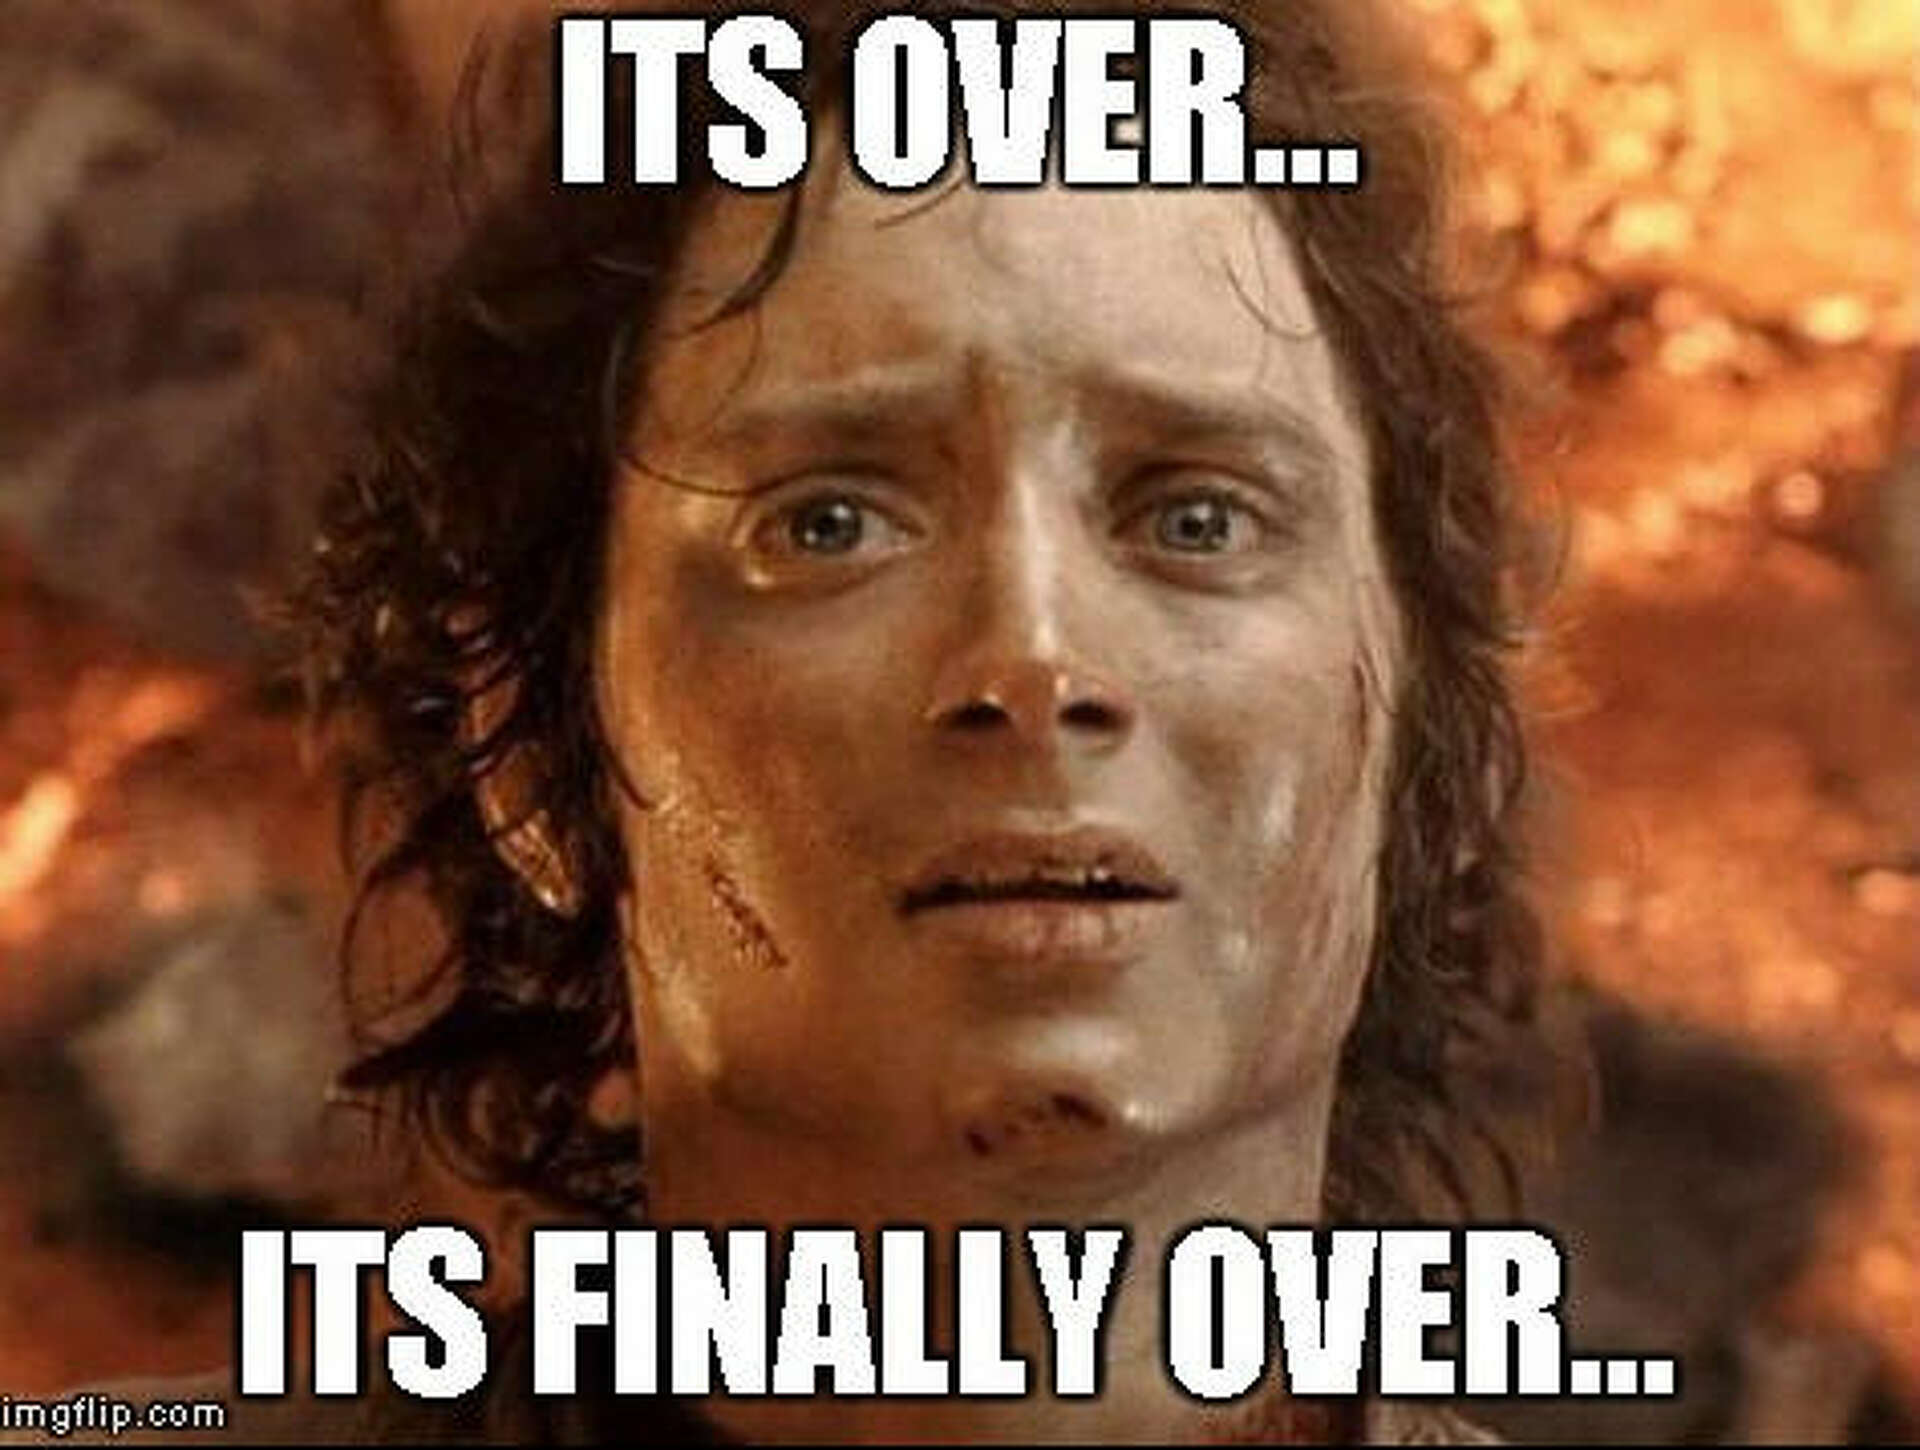